Testing Out https://github.com/hypnopump/MiniFold/blob/master/preprocessing/angle_data_preparation_py.ipynb

In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
def parse_line(raw):
    return np.array([[float(x) for x in line.split("\t") if x != ""] for line in raw])

In [71]:
names = []
seqs = []
psis = []
phis = []
pssms = []
coords = []

path = "../Data/Processed/full_under_200.txt"
# Opn file and read text
with open(path, "r") as f:
    lines = f.read().split('\n')

In [72]:
lines = [i for i in lines if i != '']

In [77]:
# Extract numeric data from text
for i,line in enumerate(lines):
    if len(names) == 601:
        break
    # Read each protein separately
    if line == "[ID]":
        names.append(lines[i+1])
    elif line == "[PRIMARY]":
        seqs.append(lines[i+1])
    elif line == "[EVOLUTIONARY]":
        pssms.append(eval(lines[i+1:i+20][0]))
    elif line == "[TERTIARY]":
        coords.append(eval(lines[i+1:i+3][0]))
        # Progress control
        if len(names)%50 == 0:
            print("Currently @ ", len(names), " out of n")

NameError: name 'TERTIARY' is not defined

In [78]:
lines[i+1:i+20]

['[[0.0, 0.4306620209059233, 0.009155645981688708, 0.011918951132300359, 0.018871191135734072, 0.002238567316917173, 0.0, 0.0, 0.1336455893832943, 0.1172155454971125, 0.055095988762291236, 0.09220839096357768, 0.0991544965411222, 0.08910738976801351, 0.0, 0.015763697581879406, 0.16097934200459063, 0.012857798867289145, 0.0, 0.04819461444308447, 0.03144078144078145, 0.0, 0.0028985507246376816, 0.04317315026697178, 0.013113754193351632, 0.0, 0.040719841390879974, 0.11412463812280971, 0.10837138508371388, 0.11013081837541834, 0.09701946472019464, 0.3134600760456274, 0.0, 0.31778115501519755, 0.07394473124810202, 0.8881469115191988, 0.23550834597875567, 0.23292867981790596, 0.0, 0.026551357912304657, 0.02412746585735964, 0.0, 0.0, 0.0, 0.0, 0.678652708238507, 0.012439320388349513, 0.0, 0.0, 0.6286407766990293, 0.8056735436893204, 0.0, 0.012602490130580018, 0.05680437424058322, 0.0, 0.2036446469248292, 0.013059984813971151, 0.005466140297600971, 0.0, 0.2856492027334852, 0.011866727521679596

In [60]:
def separate_coords(full_coords, pos): # pos can be either 0(n_term), 1(calpha), 2(cterm)
    res = []
    for i in range(len(full_coords[1])):
        if i%3 == pos:
            res.append([full_coords[j][i] for j in range(3)])

    return np.array(res)

In [61]:
# Organize by atom type
coords_nterm = [separate_coords(full_coords, 0) for full_coords in coords]
coords_calpha = [separate_coords(full_coords, 1) for full_coords in coords]
coords_cterm = [separate_coords(full_coords, 2) for full_coords in coords]

In [62]:
# Check everything's ok
print("Length coords_calpha: ", len(coords_cterm))
print("Length coords_calpha[1]: ", len(coords_cterm[1]))
print("Length coords_calpha[1][1]: ", len(coords_cterm[1][1]))

Length coords_calpha:  600
Length coords_calpha[1]:  142
Length coords_calpha[1][1]:  3


In [63]:
def get_dihedral(coords1, coords2, coords3, coords4):
    """Returns the dihedral angle in degrees."""

    a1 = coords2 - coords1
    a2 = coords3 - coords2
    a3 = coords4 - coords3

    v1 = np.cross(a1, a2)
    v1 = v1 / (v1 * v1).sum(-1)**0.5
    v2 = np.cross(a2, a3)
    v2 = v2 / (v2 * v2).sum(-1)**0.5
    porm = np.sign((v1 * a3).sum(-1))
    rad = np.arccos((v1*v2).sum(-1) / ((v1**2).sum(-1) * (v2**2).sum(-1))**0.5)
    if not porm == 0:
        rad = rad * porm

    return rad

In [64]:
# Compute angles for a protein
phis, psis = [], [] # phi always starts with a 0 and psi ends with a 0
ph_angle_dists, ps_angle_dists = [], []
for k in range(len(coords)):
    phi, psi = [0.0], []
    # Use our own functions inspired from bioPython
    for i in range(len(coords_calpha[k])):
        # Calculate phi, psi
        # CALCULATE PHI - Can't calculate for first residue
        if i>0:
            phi.append(get_dihedral(coords_cterm[k][i-1], coords_nterm[k][i], coords_calpha[k][i], coords_cterm[k][i])) # my_calc
            
        # CALCULATE PSI - Can't calculate for last residue
        if i<len(coords_calpha[k])-1: 
            psi.append(get_dihedral(coords_nterm[k][i], coords_calpha[k][i], coords_cterm[k][i], coords_nterm[k][i+1])) # my_calc
        
    # Add an extra 0 to psi (unable to claculate angle with next aa)
    psi.append(0)
    # Add protein info to register
    phis.append(phi)
    psis.append(psi)


/var/folders/d6/c94lxys15wjgqlyz38dwx_5w0000gn/T/ipykernel_10125/4150488568.py:9: RuntimeWarning: invalid value encountered in true_divide
  v1 = v1 / (v1 * v1).sum(-1)**0.5
/var/folders/d6/c94lxys15wjgqlyz38dwx_5w0000gn/T/ipykernel_10125/4150488568.py:11: RuntimeWarning: invalid value encountered in true_divide
  v2 = v2 / (v2 * v2).sum(-1)**0.5


In [65]:
def stringify(vec):
    """ Helper function to save data to .txt file. """
    line = ""
    for v in vec:
        line = line+str(v)+" "
    return line

# Test function
print([stringify([1,2,3,4,5,6])])

['1 2 3 4 5 6 ']


In [66]:
# Check angles distribution is a Ramachandran Plot (2nd and 3rd quads. dense)
n = 100
test_phi = []
for i in range(n):
    for test in phis[i]:
        test_phi.append(test)
test_phi = np.array(test_phi)

test_psi = []
for i in range(n):
    for test in psis[i]:
        test_psi.append(test)
test_psi = np.array(test_psi)

# For quadrants following trigonometry positions
quads = [0,0,0,0]
for i in range(len(test_phi)):
    if test_phi[i] >= 0 and test_psi[i] >= 0:
        quads[0] += 1
    elif test_phi[i] < 0 and test_psi[i] >= 0:
        quads[1] += 1
    elif test_phi[i] < 0 and test_psi[i] < 0:
        quads[2] += 1
    else:
        quads[3] += 1
        
print("Quadrants: ", quads, " from ", len(test_phi))

Quadrants:  [542, 4459, 4458, 561]  from  10020


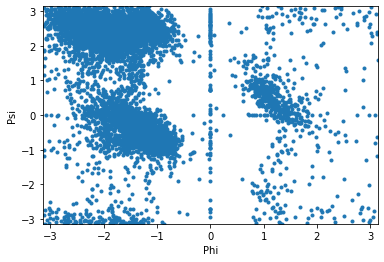

In [67]:
plt.scatter(test_phi, test_psi, marker=".")
plt.xlim(-np.pi, np.pi)
plt.xlabel("Phi")
plt.ylabel("Psi")
plt.ylim(-np.pi, np.pi)
plt.show()

In [68]:
# Data is OK. Can save it to file.
with open("../Data/Processed-1/training_30.txt", "a") as f:
    for k in range(len(names)-1):
        # ID
        f.write("\n[ID]\n")
        f.write(names[k])
        # Seq
        f.write("\n[PRIMARY]\n")
        f.write(seqs[k])
        # PSSMS
        f.write("\n[EVOLUTIONARY]\n")
        for j in range(len(pssms[k])):
            f.write(stringify(pssms[k][j])+"\n")
        # PHI
        f.write("\n[PHI]\n")
        f.write(stringify(phis[k]))
        # PSI
        f.write("\n[PSI]\n")
        f.write(stringify(psis[k]))